#### Contexto 
Características de entrada en orden:

1) CRIM: tasa de criminalidad per cápita por ciudad
2) ZN: proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados
3) INDUS: proporción de acres de negocios no minoristas por ciudad
4) CHAS: variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)
5) NOX: concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M]
6) RM: número promedio de habitaciones por vivienda
7) AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8) DIS: distancias ponderadas a cinco centros de empleo de Boston
9) RAD: índice de accesibilidad a las autopistas radiales
10) TAX: tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k]
11) PTRATIO: proporción alumno-maestro por ciudad
12) B: El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
13) LSTAT: % de población de menor estatus socioeconómico

Variable de salida:

14) MEDV: Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$]


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, HuberRegressor, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler

In [125]:
df_precios_casas = pd.read_csv("house-prices-tp.csv")
df_original = df_precios_casas.copy()

# Análisis descriptivo

In [126]:
df_precios_casas.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


In [127]:
df_precios_casas.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,533.000000,534.000000,541.000000,533.000000,532.000000,535.000000,532.000000,541.000000,528.000000,538.000000,528.000000,534.000000,534.000000,535.000000
mean,5.845517,13.197175,11.218725,0.090056,0.560050,6.291839,67.632303,3.944102,9.699379,409.575089,18.429904,347.806040,13.028092,22.746809
std,13.828631,24.902981,6.942021,0.286531,0.119472,0.782403,28.461925,2.255689,8.684495,167.689379,2.194759,99.636208,7.579972,9.491452
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.084470,0.000000,5.130000,0.000000,0.453000,5.875500,42.275000,2.112100,4.000000,279.000000,17.000000,369.530000,7.150000,16.750000
50%,0.315330,0.000000,9.690000,0.000000,0.538000,6.208000,76.500000,3.340107,5.000000,335.000000,19.000000,390.815000,11.465000,21.200000
75%,4.871410,20.000000,18.100000,0.000000,0.643986,6.638500,93.825000,5.400700,23.632660,666.000000,20.200000,395.890000,17.205000,26.300000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [128]:
df_precios_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


### Verificamos valores nulos

In [129]:
conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       23
ZN         22
INDUS      15
CHAS       23
NOX        24
RM         21
AGE        24
DIS        15
RAD        28
TAX        18
PTRATIO    28
B          22
LSTAT      22
MEDV       21
dtype: int64

In [130]:
filas_nan = []

for index, row in df_precios_casas.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_precios_casas.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")


Filas eliminadas: 21


In [131]:
conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       11
ZN         11
INDUS       4
CHAS        9
NOX         9
RM          7
AGE        11
DIS         5
RAD        12
TAX         9
PTRATIO     9
B           9
LSTAT       9
MEDV        0
dtype: int64

### Imputaremos la columna binaria con la moda

In [132]:
df_precios_casas['CHAS'] = df_precios_casas['CHAS'].fillna(df_precios_casas['CHAS'].mode()[0])

### Y el resto de columnas seran inputadas con KNN

In [133]:
# Crear el imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Aplicar KNNImputer al DataFrame completo
df_precios_casas = pd.DataFrame(imputer.fit_transform(df_precios_casas), columns=df_precios_casas.columns)


In [134]:
df_precios_casas

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.071510,0.000000,4.490000,0.0,0.449000,6.121000,56.800000,3.747600,3.000000,247.000000,18.500000,395.150000,8.440000,22.200000
1,0.082650,0.000000,13.920000,0.0,0.437000,6.127000,18.400000,5.502700,4.000000,289.000000,16.000000,396.900000,8.580000,23.900000
2,0.128160,12.500000,6.070000,0.0,0.409000,5.885000,33.000000,6.498000,4.000000,345.000000,18.900000,396.900000,8.790000,20.900000
3,0.088730,21.000000,5.640000,0.0,0.439000,5.963000,45.700000,6.814700,4.000000,243.000000,16.800000,395.560000,13.450000,19.700000
4,0.114320,0.000000,8.560000,0.0,0.520000,6.781000,71.300000,2.856100,5.000000,384.000000,20.900000,395.580000,7.670000,26.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,0.082440,30.000000,4.930000,0.0,0.428000,6.481000,18.500000,6.189900,6.000000,300.000000,16.600000,379.410000,6.360000,23.700000
531,0.475470,0.000000,9.900000,0.0,0.544000,6.113000,58.800000,4.001900,4.000000,304.000000,18.400000,396.230000,12.730000,21.000000
532,0.249800,0.000000,21.890000,0.0,0.624000,5.857000,98.200000,1.668600,4.000000,437.000000,21.200000,392.040000,21.320000,13.300000
533,32.504013,6.528591,8.937346,1.0,0.624891,4.016588,37.293656,5.243777,20.416908,197.236588,19.639059,6.267059,7.033962,23.028798


In [135]:
conteo_nan = df_precios_casas.isnull().sum()
conteo_nan

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Train-Test

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df_precios_casas.drop(columns=['MEDV']), df_precios_casas['MEDV'], test_size=0.2, random_state=42)

df_entrenamiento=pd.concat([X_train,y_train],axis=1)
df_test=pd.concat([X_test,y_test],axis=1)

# Analisis descriptivo

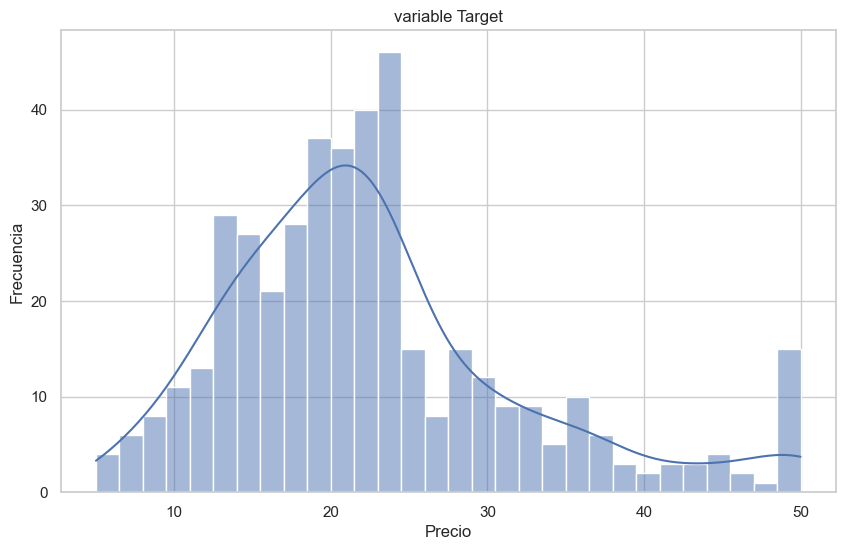

In [137]:
plt.figure(figsize=(10, 6))
sns.histplot(df_entrenamiento['MEDV'], bins=30, kde=True)
plt.title('variable Target')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

matriz de correlacion

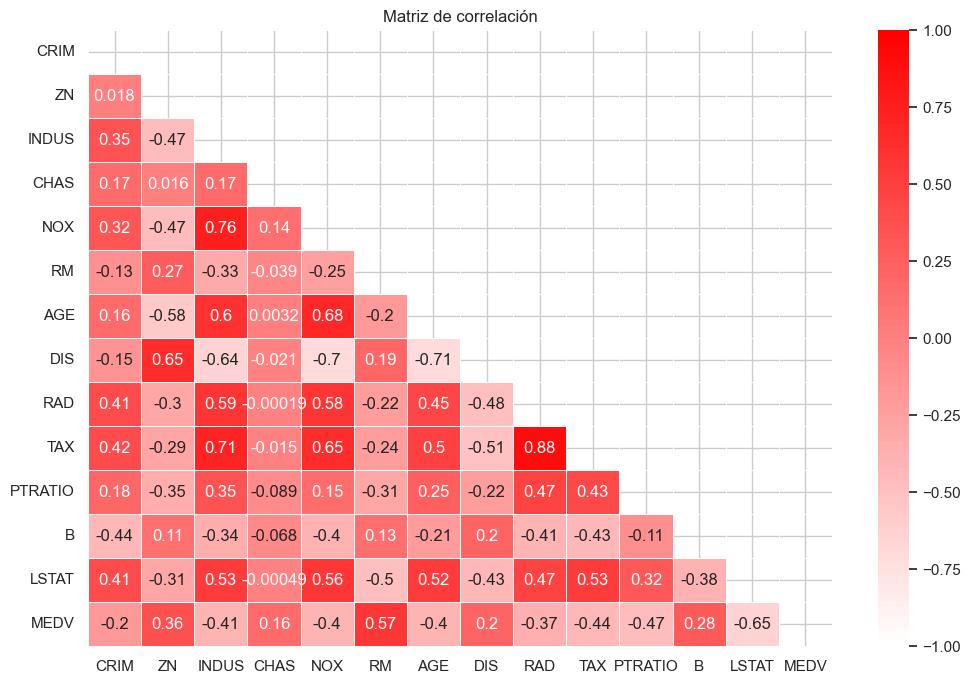

In [138]:
corr_matrix = df_entrenamiento.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=cm, center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

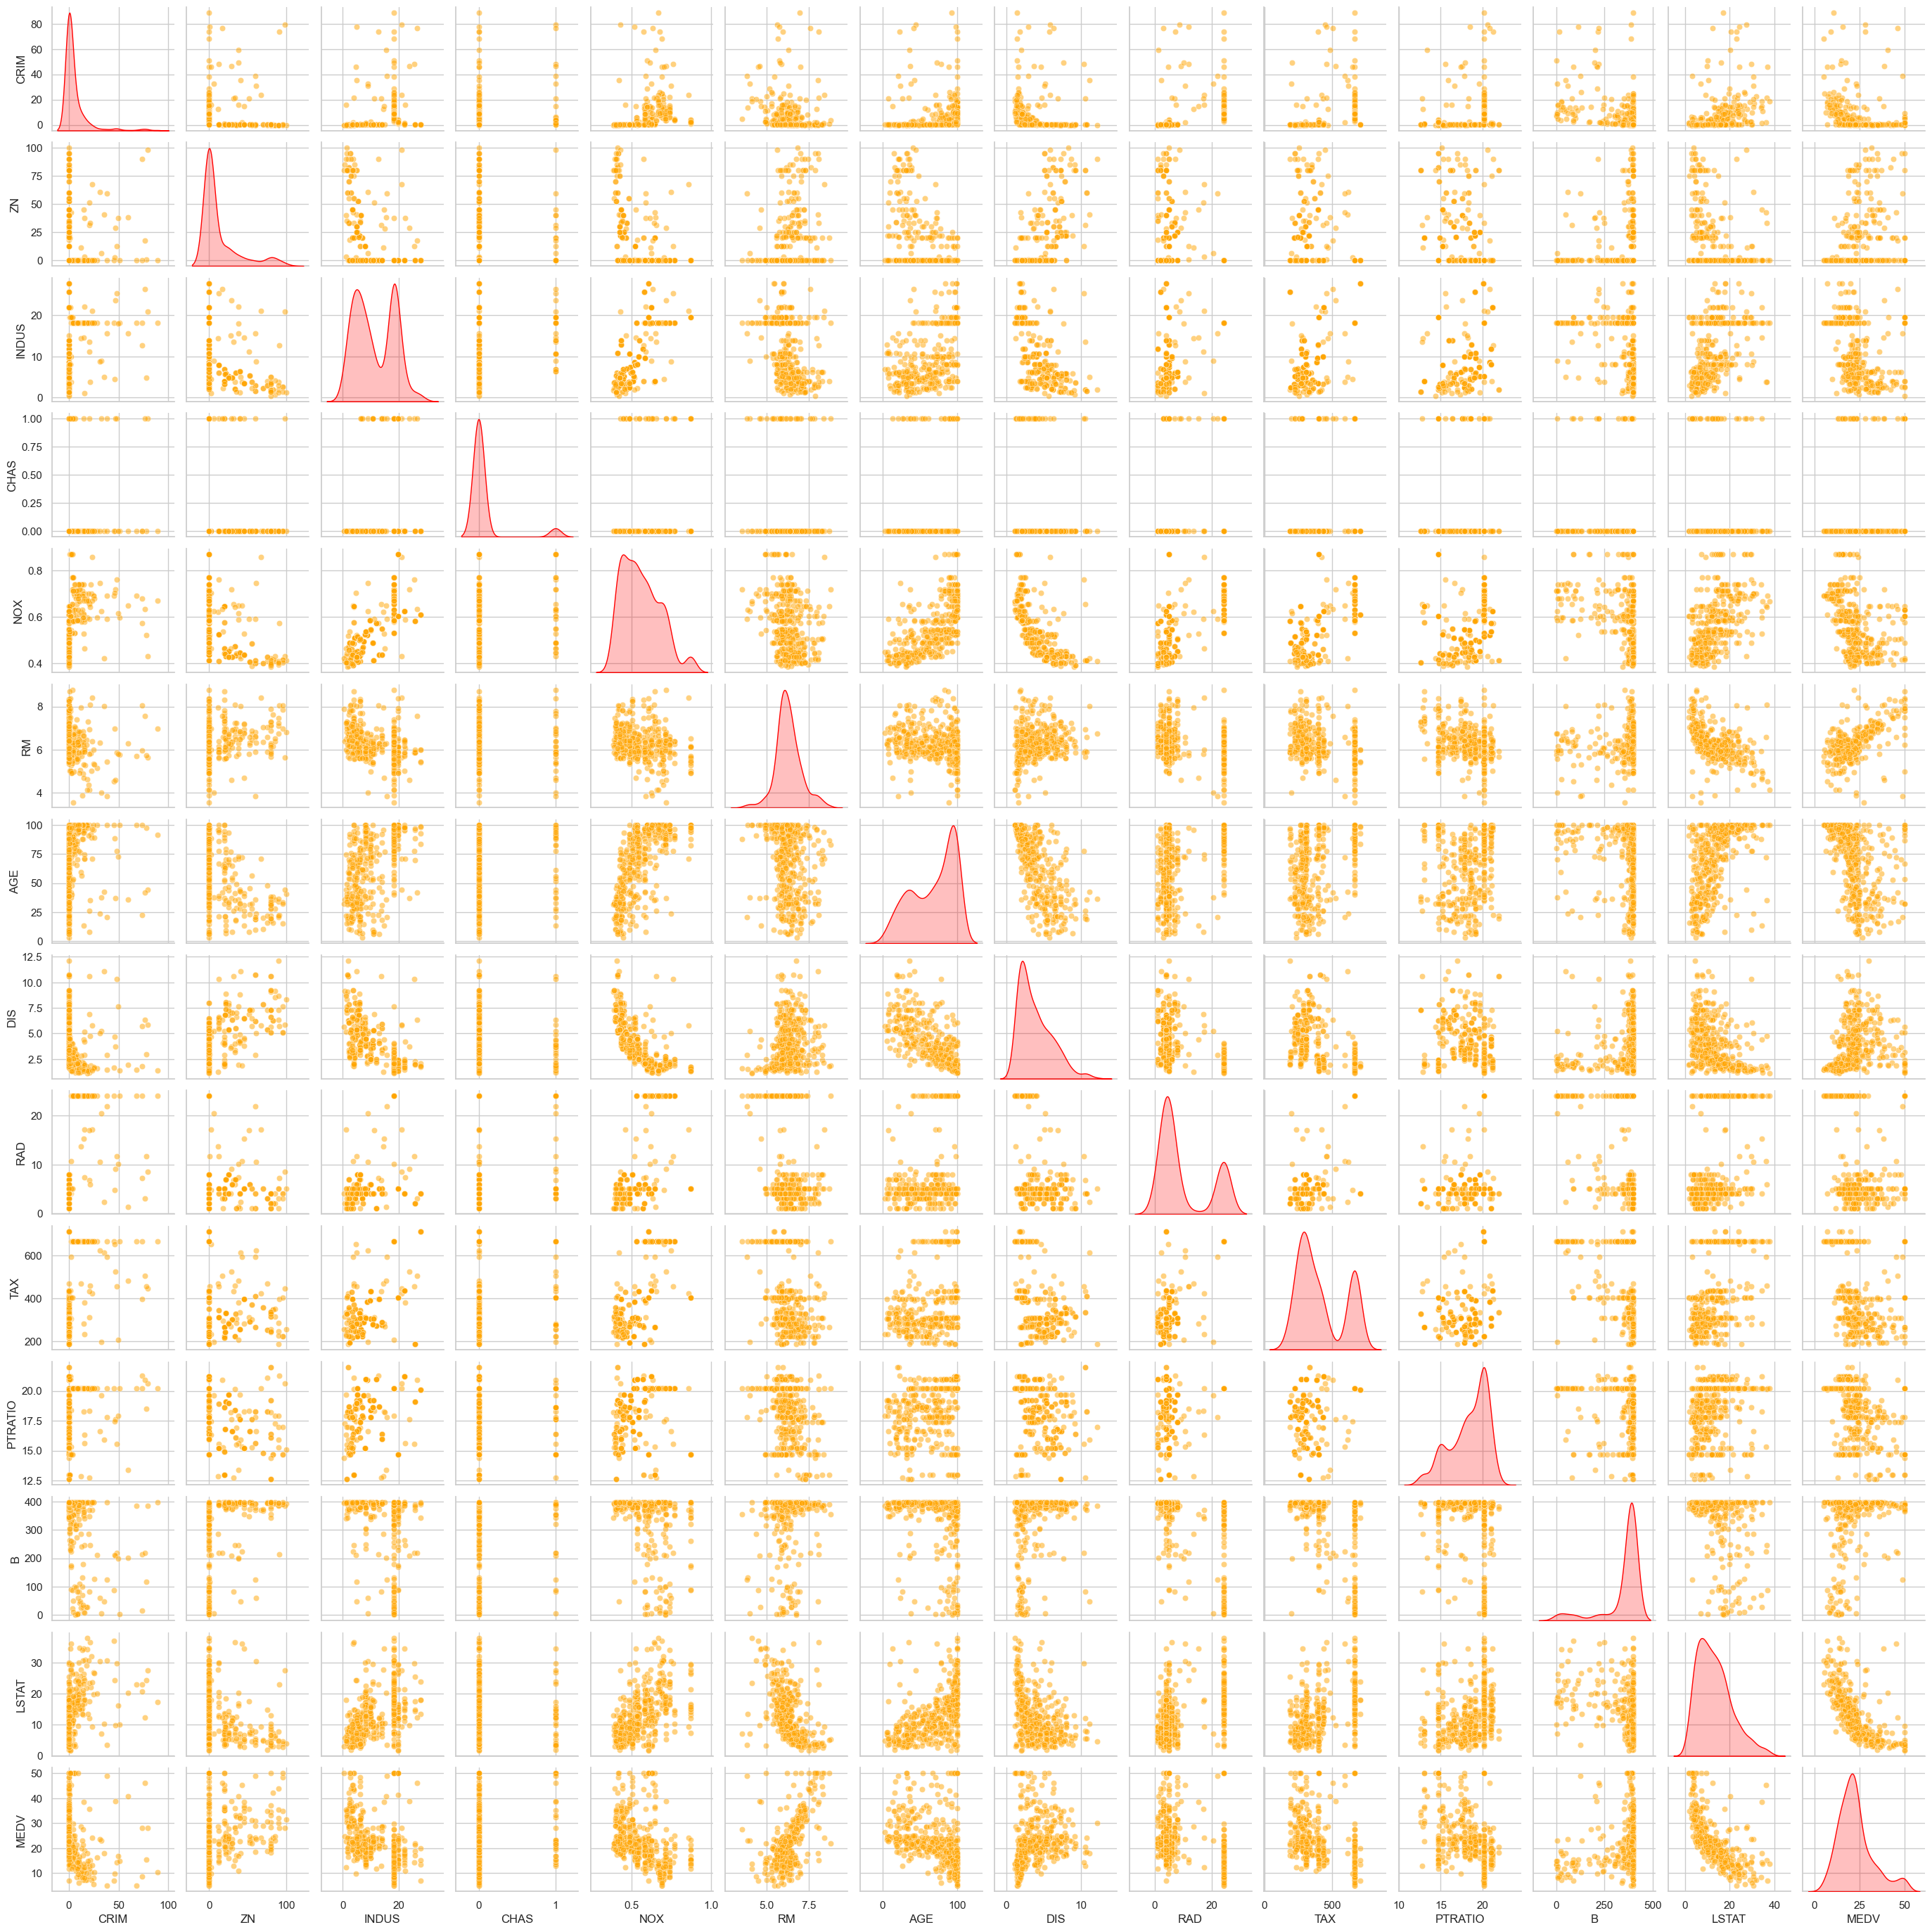

In [139]:
sns.pairplot(df_entrenamiento, diag_kind='kde', plot_kws={'alpha': 0.5, 'color': 'orange'}, diag_kws={'color': 'red'}, height=2, aspect=1)

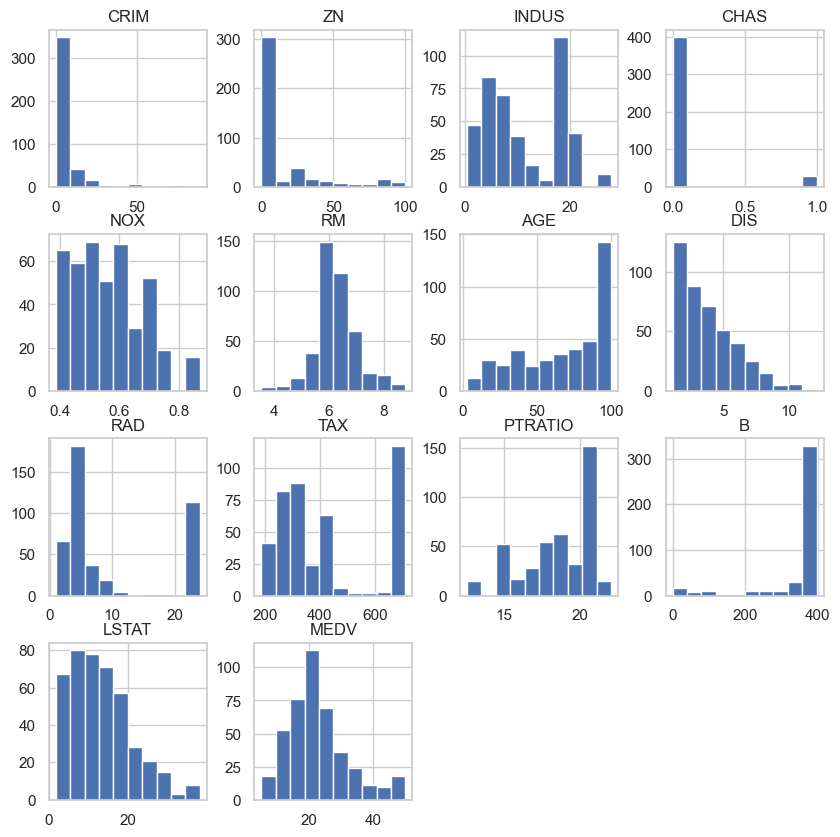

In [140]:
#histograma de data_imputed
df_entrenamiento.hist(figsize=(10, 10))
plt.show()


### Exploracion de outliers

In [141]:
# Separar variable de salida (MEDV) y características
df_precios_casas_target = df_precios_casas['MEDV']
df_precios_casas = df_precios_casas.drop(columns=['MEDV'])

C:\Users\franco\AppData\Local\Temp\ipykernel_13568\2388619411.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_precios_casas, x='CHAS', palette="viridis")


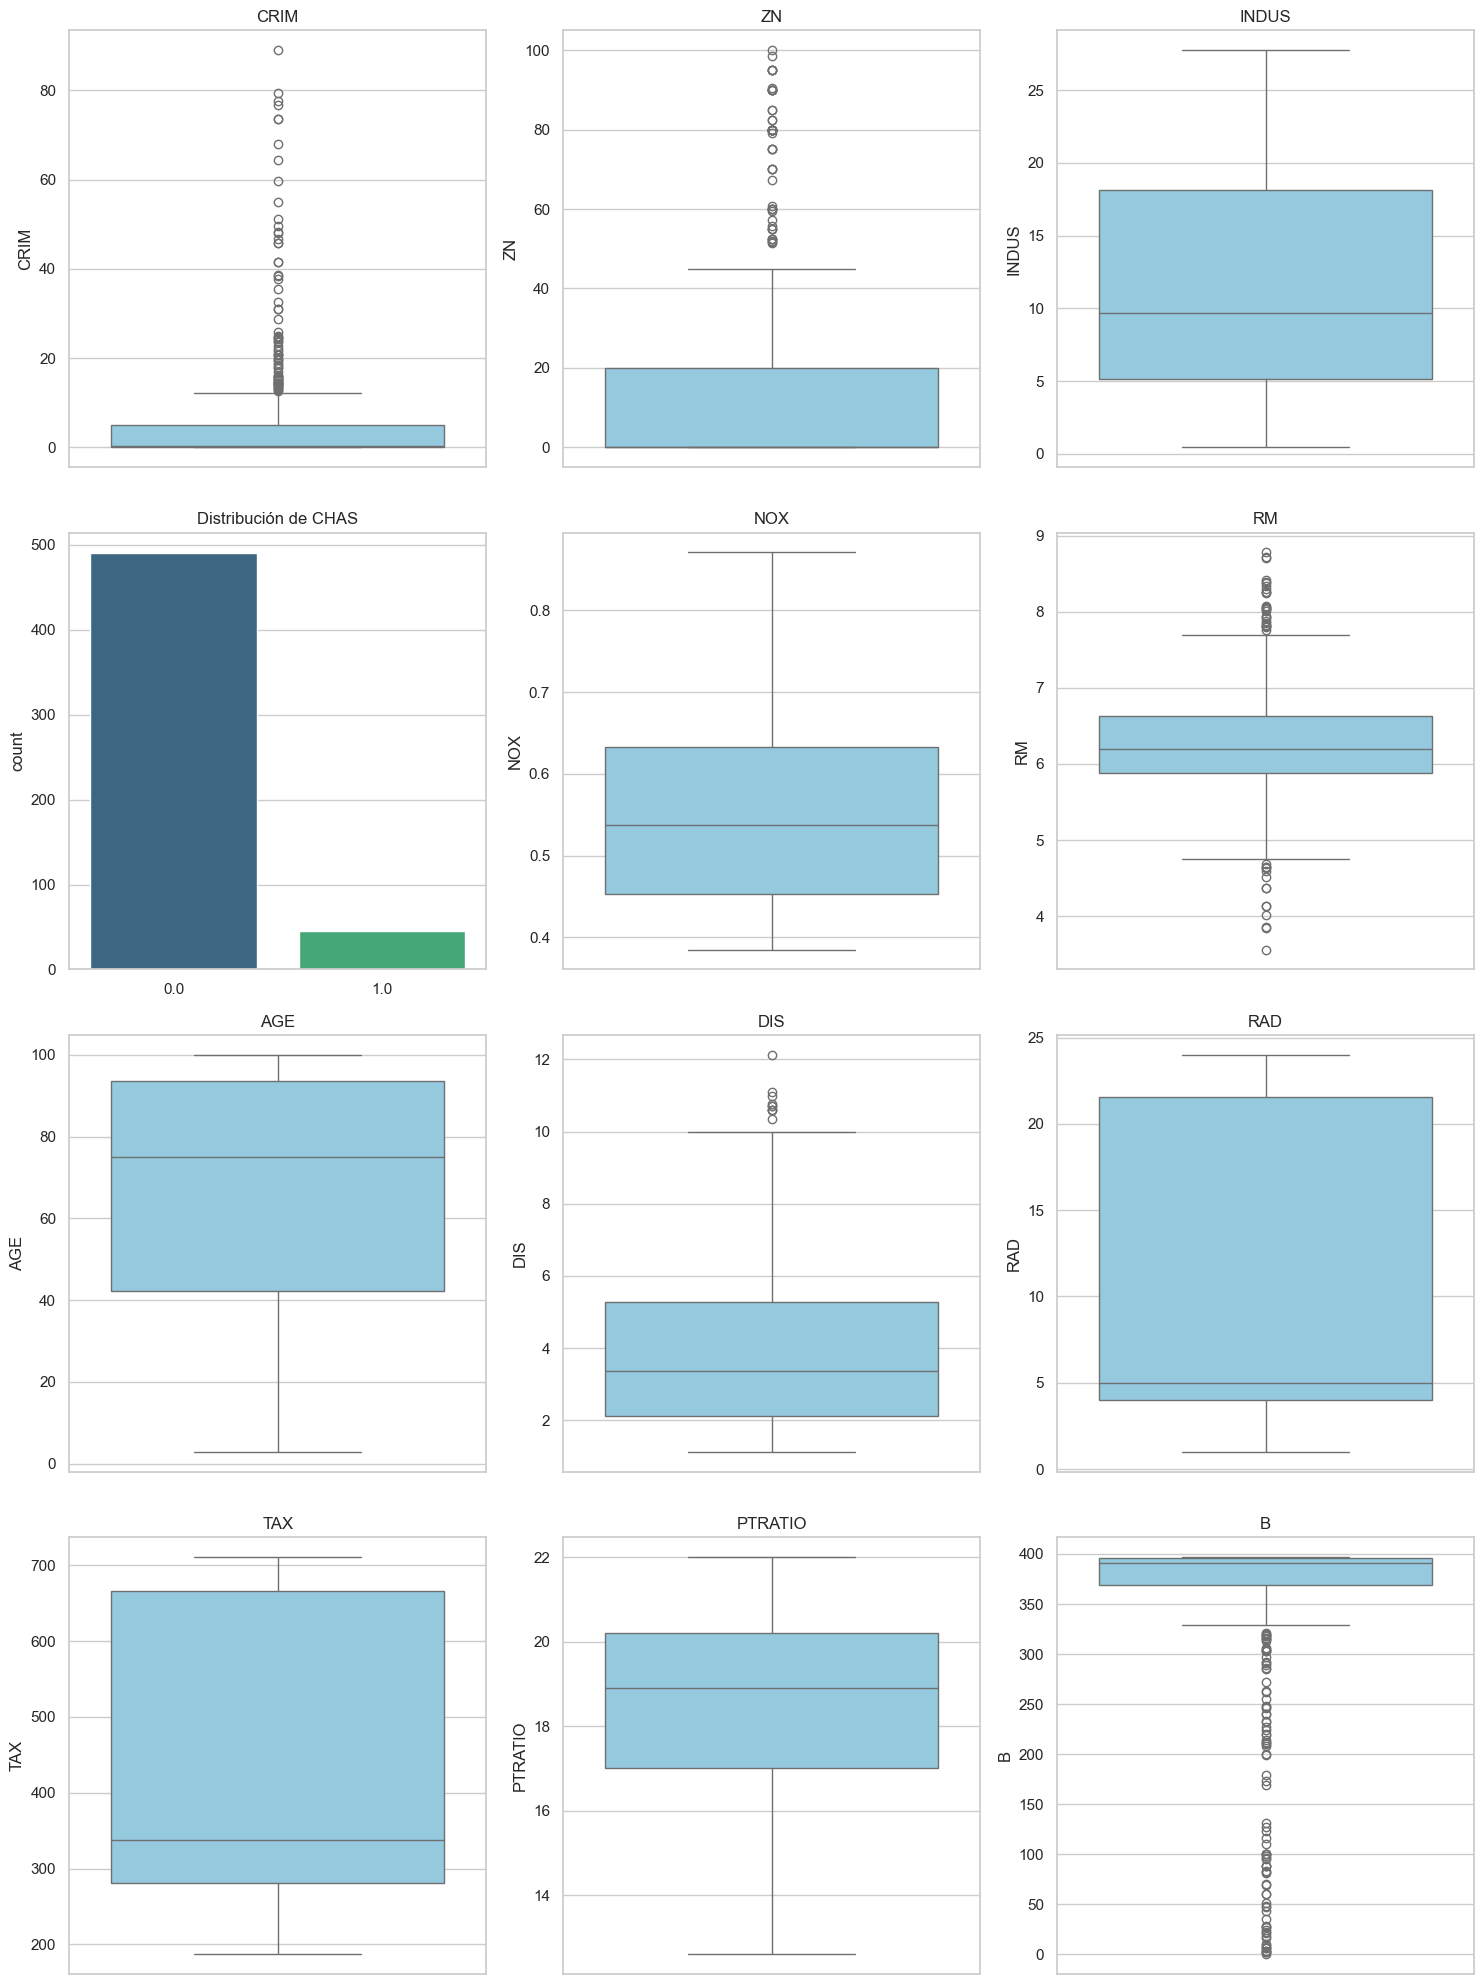

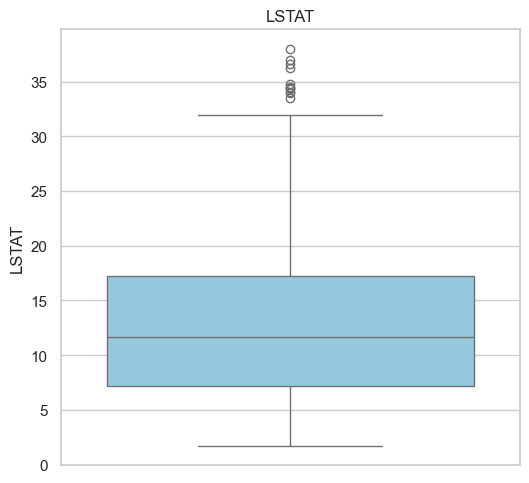

In [142]:
# Configuración de estilo de seaborn
sns.set_theme(style="whitegrid")

# Número de columnas para los boxplots
num_columns = len(df_precios_casas.columns)

# Calcular el número de figuras necesarias
max_plots_per_figure = 12
num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure

for fig_index in range(num_figures):
    start_index = fig_index * max_plots_per_figure
    end_index = min(start_index + max_plots_per_figure, num_columns)
    
    # Crear una figura y una serie de subplots
    plt.figure(figsize=(15, 5 * ((end_index - start_index + 2) // 3)))
    
    # Crear gráficos para cada columna del DataFrame de características
    for i, column in enumerate(df_precios_casas.columns[start_index:end_index]):
        plt.subplot((end_index - start_index + 2) // 3, 3, i + 1)  # Define la posición del subplot
        if column == 'CHAS':
            # Crear un gráfico de barras para la columna CHAS
            sns.countplot(data=df_precios_casas, x='CHAS', palette="viridis")
            plt.title('Distribución de CHAS')
        else:
            # Crear un boxplot para otras columnas
            sns.boxplot(data=df_precios_casas[column], color="skyblue")
            plt.title(column)
        plt.xlabel('')  # Eliminar la etiqueta del eje x para una mejor visualización

    # Ajustar el espaciado entre subplots
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

# Escalamiento de datos

In [143]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementación de Modelos de Regresión

In [144]:
regresiones_lineales = {
    "Linear Regression": LinearRegression(),
    "SGD Regression": SGDRegressor(max_iter=1000, tol=1e-3),
    "Lasso": LassoCV(cv=5, random_state=42),
    "Ridge": RidgeCV(cv=5, alphas=np.logspace(-6, 6, 13)),
    "ElasticNet": ElasticNetCV(cv=5, random_state=42)
}

resultados = pd.DataFrame()

for name, regressor in regresiones_lineales.items():
    # Entrenar el modelo
    regressor.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_train_pred = regressor.predict(X_train_scaled)
    y_test_pred = regressor.predict(X_test_scaled)
    
    # Calcular métricas
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Guardar resultados
    resultado = pd.DataFrame({
        "Regresión lineal": [name],
        "Train RMSE": [train_rmse],
        "Test RMSE": [test_rmse],
        "Train R2": [train_r2],
        "Test R2": [test_r2]
    })
    resultados = pd.concat([resultados, resultado], ignore_index=True)

print(resultados)

    Regresión lineal  Train RMSE  Test RMSE  Train R2   Test R2
0  Linear Regression    5.508005   7.053167  0.668309  0.401874
1     SGD Regression    5.517959   6.984417  0.667109  0.413478
2              Lasso    5.509446   7.032640  0.668136  0.405351
3              Ridge    5.514978   6.918830  0.667469  0.424442
4         ElasticNet    5.519319   6.914293  0.666945  0.425196


c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWa

Coeficientes del modelo de regresión lineal:
[ 0.61341159  1.85805034  0.20964407  1.52556767 -1.98668173  2.62335978
 -1.389465   -4.24287609  1.3807135  -1.85970785 -1.97183672  0.62982478
 -3.49694272]
0.6683093044186422

Coeficientes del modelo Lasso:
[ 0.44659024  1.64821293 -0.          1.47202736 -1.63467081  2.58080174
 -1.23432644 -3.72889154  0.46206106 -0.96953178 -1.8077584   0.49688469
 -3.50404307]
0.664506800627791

Coeficientes del modelo Ridge:
[ 0.6130631   1.85635161  0.20792582  1.52544817 -1.98426894  2.62323432
 -1.38879906 -4.23906163  1.37724151 -1.85582902 -1.97130904  0.63001072
 -3.49625193]
0.6683091985704166

Coeficientes del modelo ElasticNet:
[ 0.59911228  1.81061622  0.13791337  1.52326603 -1.90985071  2.6161146
 -1.36643535 -4.14097742  1.2587026  -1.72438091 -1.95001145  0.62721829
 -3.48268933]
0.6682081073481472


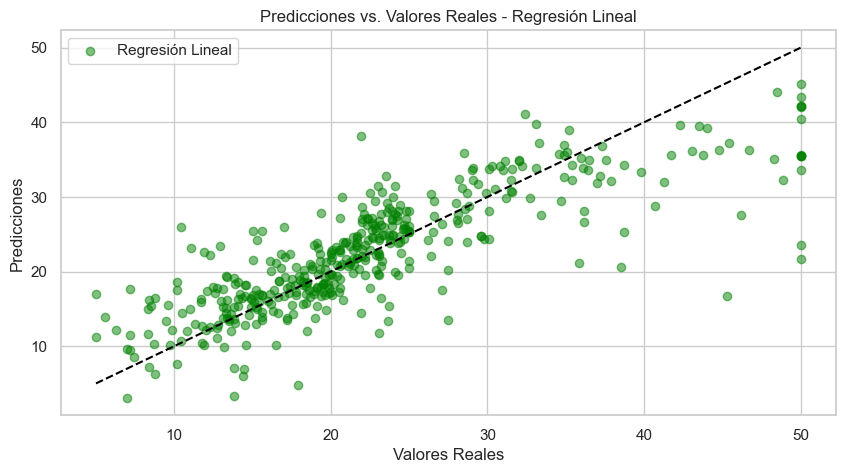

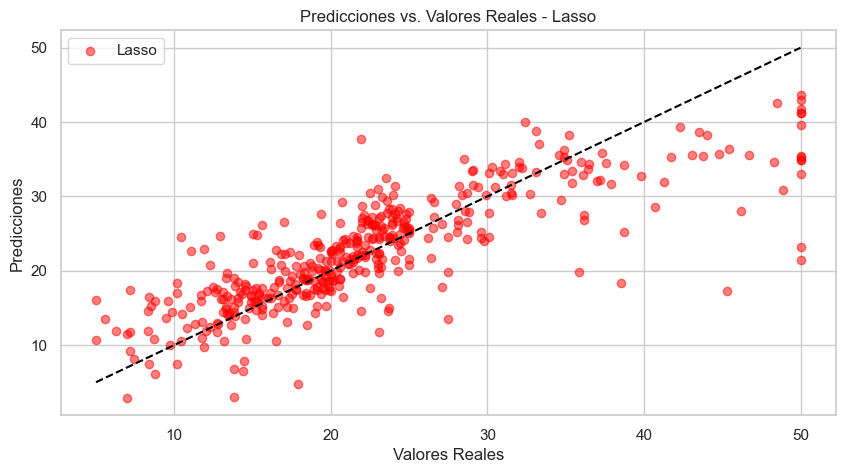

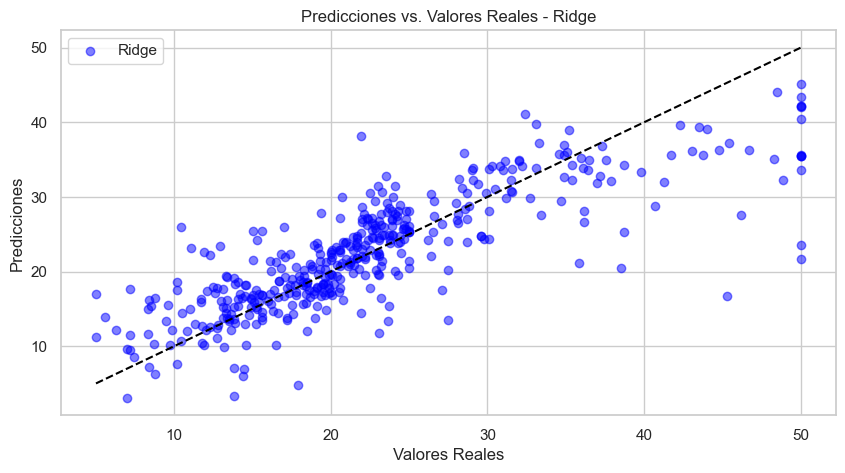

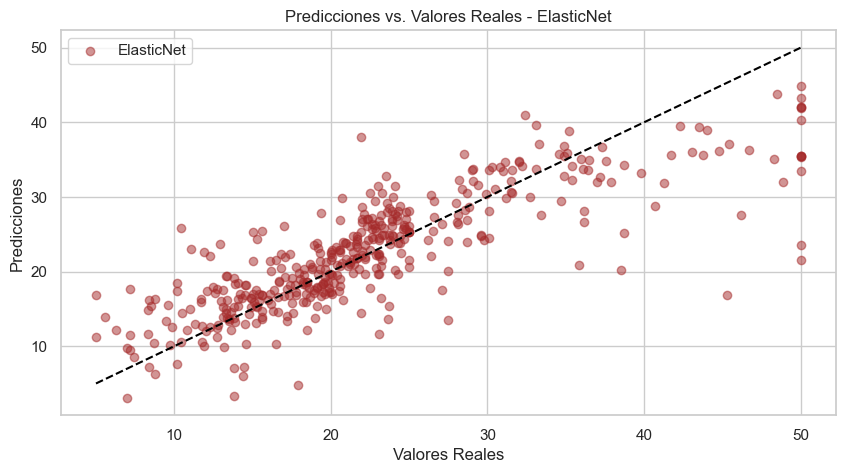

In [145]:

# Crear modelos de regresión lineal, Lasso y Ridge
lr = LinearRegression()
lasso = Lasso(alpha=0.1)  # alpha controla la fuerza de la regularización L1 (Lasso)
ridge = Ridge(alpha=0.1)  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.5)

# Inicializar modelos con los mismos datos
lr.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
elasticnet.fit(X_train_scaled, y_train)

# Mostrar coeficientes
print("Coeficientes del modelo de regresión lineal:")
print(lr.coef_)
print(lr.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print(lasso.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print(ridge.score(X_train_scaled, y_train))

print("\nCoeficientes del modelo ElasticNet:")
print(elasticnet.coef_)
print(elasticnet.score(X_train_scaled, y_train))

# Gráfico para Regresión Lineal
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lr.predict(X_train_scaled), label='Regresión Lineal', color='green', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Regresión Lineal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para Lasso
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lasso.predict(X_train_scaled), label='Lasso', color='red', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Lasso')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para Ridge
plt.figure(figsize=(10, 5))
plt.scatter(y_train, ridge.predict(X_train_scaled), label='Ridge', color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - Ridge')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

# Gráfico para ElasticNet
plt.figure(figsize=(10, 5))
plt.scatter(y_train, elasticnet.predict(X_train_scaled), label='ElasticNet', color='brown', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Predicciones vs. Valores Reales - ElasticNet')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


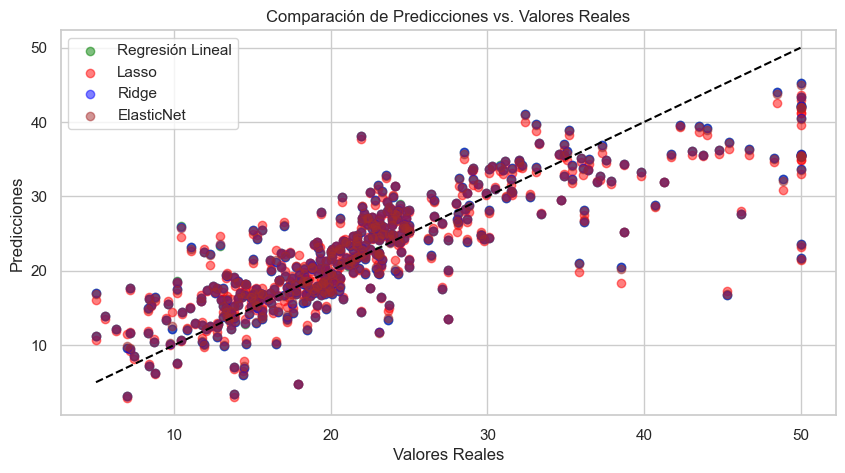

In [146]:
# Graficar predicciones vs. valores reales
plt.figure(figsize=(10, 5))
plt.scatter(y_train, lr.predict(X_train_scaled), label='Regresión Lineal', color='green', alpha=0.5)
plt.scatter(y_train, lasso.predict(X_train_scaled), label='Lasso', color='red', alpha=0.5)
plt.scatter(y_train, ridge.predict(X_train_scaled), label='Ridge', color='blue', alpha=0.5)
plt.scatter(y_train, elasticnet.predict(X_train_scaled), label='ElasticNet', color='brown', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', color='black')
plt.legend()
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()


## Gradiente descendente

hay que consultar el tema de los shape y los reshape para poder implementar bien las funciones y que grafique correctamente

In [147]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [148]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=200):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    """
    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características

    o = X_val.shape[0]  # Número de ejemplos de validación

    # Poner columna de unos a las matrices X para el término de sesgo (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    
    # Convertir y_train y y_val a arrays de NumPy y asegurarse de que sean vectores columna
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_val = y_val.to_numpy().reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de validación en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de validación
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

In [149]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

In [150]:
"""df = pd.read_csv('house-prices-tp.csv')
# Separar características (X) y objetivo (y)
X = df.drop(columns=['MEDV']).values
y = df['MEDV'].values.reshape(-1, 1)
"""
# Dividir los datos en entrenamiento, validación y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

"""# Escalar los datos para normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
"""
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)


'# Escalar los datos para normalizar las características\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_val = scaler.transform(X_val)\nX_test = scaler.transform(X_test)\n'

In [151]:
#stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=1, epochs=100)

In [152]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=200):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    """
    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características

    o = X_val.shape[0]  # Número de ejemplos de validación

    # Poner columna de unos a las matrices X para el término de sesgo (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    
    # Convertir y_train y y_val a arrays de NumPy y asegurarse de que sean vectores columna
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_val = y_val.to_numpy().reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de validación en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de validación
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

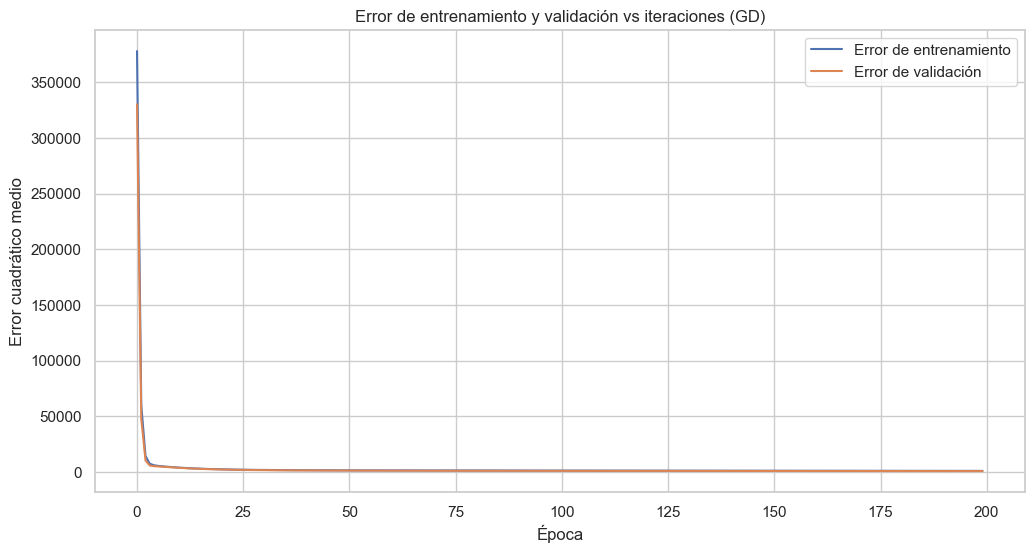

array([[ 0.26344879],
       [-0.15555995],
       [-0.8401232 ],
       [-0.90291069],
       [-1.50706353],
       [ 0.47046989],
       [-1.17965371],
       [ 0.21777654],
       [ 2.44521252],
       [ 1.18599335],
       [-0.0950804 ],
       [ 0.79596794],
       [ 0.0677657 ],
       [ 1.29102158]])

In [153]:
gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=200)

In [154]:
mini_batch_gradient_descent(X_train, y_train, X_test, y_test, epochs=100)

KeyError: '[294, 249, 73, 277, 313, 106, 16, 287, 172, 345, 71, 158, 167, 49, 4, 101, 89, 75, 131, 247, 353, 2, 11, 63, 359, 45, 352, 76, 310, 46, 39, 139, 351, 30, 25, 211, 72, 346, 234, 242, 136, 70, 86, 227, 182, 140, 117, 238, 168, 244, 302, 9, 273, 185, 10, 266, 132, 22, 116, 311, 0, 195, 281, 93, 340, 320, 55, 15, 284, 154, 299, 108, 228, 68, 268, 33, 233, 245, 18, 137, 166, 366, 322, 92, 209, 6, 204, 82, 79, 84, 173, 90, 368, 56, 341, 78, 357, 148, 307, 229, 316, 176, 77, 237, 208, 104, 329] not in index'


# Análisis de Datos y Modelado

## 1. Análisis Descriptivo de los Datos

- **Análisis de datos faltantes**:
  - Identifica si hay valores faltantes en tu dataset y decide cómo manejarlos (por ejemplo, imputación, eliminación).

- **Visualización de datos**:
  - Genera histogramas, diagramas de dispersión (scatterplots), y diagramas sde caja (boxplots) para comprender mejor la distribución de cada variable.

- **Codificación de variables categóricas**:
  - Si alguna variable es categórica, conviértela en variables numéricas (usualmente se utiliza One-Hot Encoding).

- **Matriz de correlación**:
  - Calcula la correlación entre variables para ver cómo se relacionan entre sí.

- **Estandarización o escalado de datos**:
  - Aplica técnicas de escalado como la normalización o estandarización si es necesario.

## 2. División de los Datos en Entrenamiento y Prueba

- Realiza una división de los datos en conjuntos de entrenamiento y prueba (usualmente 70% entrenamiento y 30% prueba).

## 3. Implementación de Modelos de Regresión

- **Regresión Lineal Múltiple**:
  - Usa `LinearRegression` de scikit-learn.

- **Gradiente Descendiente**:
  - Implementa regresión utilizando métodos de gradiente descendiente y analiza si hay cambios significativos.

- **Métodos de Regularización**:
  - Aplica Lasso, Ridge, y Elastic Net para ver cómo afectan los resultados.

## 4. Evaluación de Modelos

- Calcula métricas como R² Score, MSE, RMSE, MAE, MAPE tanto en el conjunto de entrenamiento como en el de prueba.

- Compara el rendimiento entre los distintos modelos.

## 5. Optimización de Hiperparámetros

- Varía los hiperparámetros en los métodos de gradiente descendiente y regularización, observa cómo cambian los resultados.

## 6. Comparación de Modelos

- Realiza una comparación final de todos los modelos para determinar cuál es el mejor basado en las métricas adecuadas.
